In [1]:
import types
import numpy as np
import pandas as pd
from botocore.client import Config
import ibm_boto3
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import cdist
import seaborn as sns
from pandas.plotting import scatter_matrix

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
# concatenate imported DFs Q1~Q4 
df_2017 = pd.concat([df_Q1, df_Q2, df_Q3, df_Q4]) 
print(df_2017.head())

    trip_id          start_time            end_time  bikeid  tripduration  \
0  13518905  3/31/2017 23:59:07   4/1/2017 00:13:24    5292           857   
1  13518904  3/31/2017 23:56:25   4/1/2017 00:00:21    4408           236   
2  13518903  3/31/2017 23:55:33   4/1/2017 00:01:21     696           348   
3  13518902  3/31/2017 23:54:46  3/31/2017 23:59:34    4915           288   
4  13518901  3/31/2017 23:53:33   4/1/2017 00:00:28    4247           415   

   from_station_id            from_station_name  to_station_id  \
0               66         Clinton St & Lake St            171   
1              199       Wabash Ave & Grand Ave             26   
2              520   Greenview Ave & Jarvis Ave            432   
3              110        Dearborn St & Erie St            142   
4              327  Sheffield Ave & Webster Ave            331   

                 to_station_name    usertype  gender  birthyear  
0          May St & Cullerton St  Subscriber    Male     1989.0  
1       

In [4]:
df_2017.reset_index(drop=True,inplace=True)
df_2017.set_index('trip_id',inplace=True)
df_2017.head()

,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
trip_id,,,,,,,,,,,
13518905,3/31/2017 23:59:07,4/1/2017 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,Subscriber,Male,1989.0
13518904,3/31/2017 23:56:25,4/1/2017 00:00:21,4408,236,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,Subscriber,Male,1990.0
13518903,3/31/2017 23:55:33,4/1/2017 00:01:21,696,348,520,Greenview Ave & Jarvis Ave,432,Clark St & Lunt Ave,Subscriber,Female,1979.0
13518902,3/31/2017 23:54:46,3/31/2017 23:59:34,4915,288,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,Subscriber,Male,1985.0
13518901,3/31/2017 23:53:33,4/1/2017 00:00:28,4247,415,327,Sheffield Ave & Webster Ave,331,Halsted St & Blackhawk St (*),Subscriber,Female,1989.0


In [5]:
#drop unneeded column
df_stationQ3Q4 = df_stationQ3Q4.drop('Unnamed: 7',axis=1)
#concatenate station DFs of Q1~Q4 
df_stations = pd.concat([df_stationQ1Q2, df_stationQ3Q4]) 
#drop duplicates ID
df_stations = df_stations.drop_duplicates('id', keep='last')
#set id column to index as integer
df_stations.index = df_stations['id'].astype(int)
df_stations.head()

,id,name,city,latitude,longitude,dpcapacity,online_date
id,,,,,,,
2,2,Buckingham Fountain,Chicago,41.876393,-87.620328,27,6/10/2013 10:43
3,3,Shedd Aquarium,Chicago,41.867226,-87.615355,55,6/10/2013 10:44
4,4,Burnham Harbor,Chicago,41.856268,-87.613348,23,6/10/2013 10:46
5,5,State St & Harrison St,Chicago,41.874053,-87.627716,23,6/10/2013 10:46
6,6,Dusable Harbor,Chicago,41.885041,-87.612794,39,6/10/2013 11:18


In [6]:
#counts Top 5 stations with the most starts 
top5 = df_2017['from_station_id'].value_counts()
top5 = pd.DataFrame(top5.head())
top5

,from_station_id
35,97571
76,53400
192,50911
91,49832
177,47908


In [7]:
#rename column
top5.rename(columns={'from_station_name':'Counts'}, inplace=True)
#obtain station names from top5 ids, and set them to station name
top5['station name'] = df_stations.loc[top5.index]['name']

top5.reset_index(drop=True,inplace=True)
top5.set_index('station name',inplace=True)

#transpose for visualization
top5.transpose()

station name,Streeter Dr & Grand Ave,Lake Shore Dr & Monroe St,Canal St & Adams St,Clinton St & Washington Blvd,Theater on the Lake
from_station_id,97571,53400,50911,49832,47908


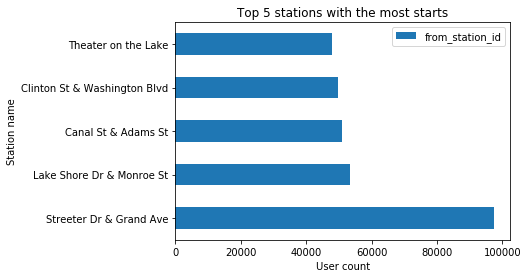

In [8]:
top5.plot.barh()
plt.title('Top 5 stations with the most starts')
plt.xlabel('User count')
plt.ylabel('Station name')
plt.show()

In [9]:
#check usertype value
df_2017['usertype'].unique()

array(['Subscriber', 'Customer', 'Dependent'], dtype=object)

In [10]:
df_subscriber = df_2017.loc[df_2017['usertype'] == 'Subscriber']
df_customer = df_2017.loc[df_2017['usertype'] == 'Customer']
df_dependent = df_2017.loc[df_2017['usertype'] == 'Dependent']

In [11]:
df_2017[df_2017['usertype'] == 'Subscriber'].tripduration.sum() / (60*60),#total hour

(584952.10166666668,)

In [12]:
#list of trip duration for usertype:Subscriber
subscriber_trip = [
    len(df_2017[df_2017['usertype'] == 'Subscriber'].index),#total trip counts
    df_2017[df_2017['usertype'] == 'Subscriber'].tripduration.sum() / (60*60),#total hour
    df_2017[df_2017['usertype'] == 'Subscriber'].tripduration.mean() / 60,#average trip minutes
    df_2017[df_2017['usertype'] == 'Subscriber'].tripduration.median() / 60#trip minutes median
]

#list of trip duration for usertype:Customer
customer_trip = [
    len(df_2017[df_2017['usertype'] == 'Customer'].index),#total trip counts
    df_2017[df_2017['usertype'] == 'Customer'].tripduration.sum() / (60*60),#total hour
    df_2017[df_2017['usertype'] == 'Customer'].tripduration.mean() / 60,#average trip minutes
    df_2017[df_2017['usertype'] == 'Customer'].tripduration.median() / 60#trip minutes median
]

#list of making trip duration for usertype:Dependent
dependent_trip = [
    len(df_2017[df_2017['usertype'] == 'Dependent'].index),#total trip counts
    df_2017[df_2017['usertype'] == 'Dependent'].tripduration.sum() / (60*60),#total hour
    df_2017[df_2017['usertype'] == 'Dependent'].tripduration.mean() / 60,#average trip minutes
    df_2017[df_2017['usertype'] == 'Dependent'].tripduration.median() / 60#trip minutes median
]

In [13]:
#create DataFrame from the lists
df_duration = pd.DataFrame([subscriber_trip,customer_trip,dependent_trip],
                          columns=['Trip Counts','Total Hour','Average minutes','Median minutes'],
                          index=['Subscriber','Customer','Dependent'])
df_duration

,Trip Counts,Total Hour,Average minutes,Median minutes
Subscriber,2992135,584952.101667,11.729794,9.533333
Customer,836872,431472.941389,30.934691,22.816667
Dependent,7,1.461944,12.530952,13.400000


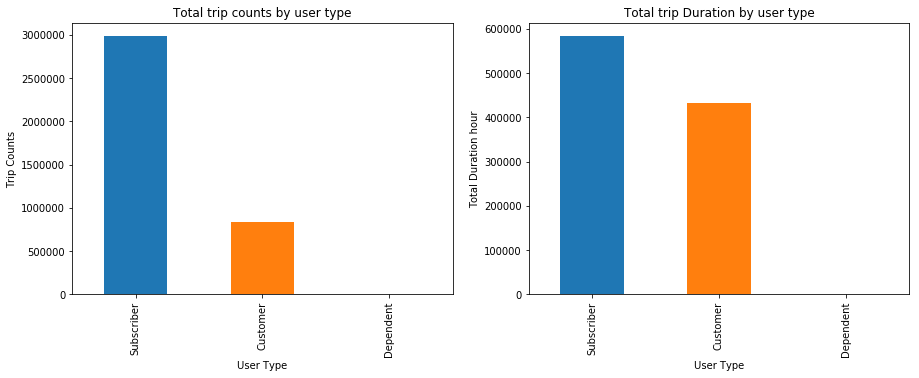

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
df_duration['Trip Counts'].plot.bar()
plt.title('Total trip counts by user type')
plt.xlabel('User Type')
plt.ylabel('Trip Counts')

plt.subplot(1,2,2)
df_duration['Total Hour'].plot.bar()
plt.title('Total trip Duration by user type')
plt.xlabel('User Type')
plt.ylabel('Total Duration hour')

plt.show()

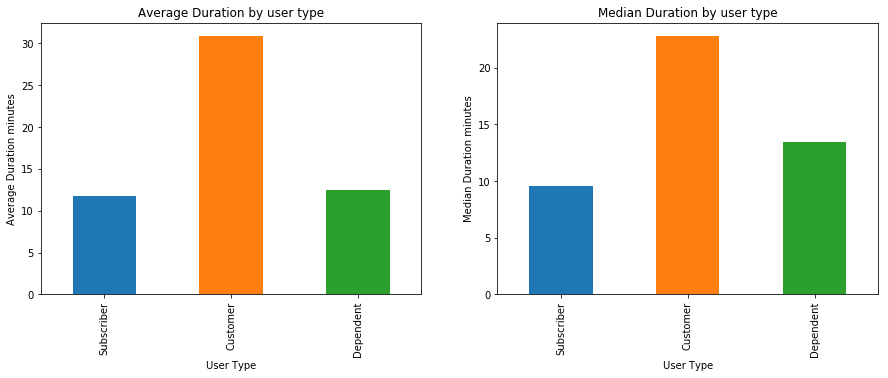

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
df_duration['Average minutes'].plot.bar()
plt.title('Average Duration by user type')
plt.xlabel('User Type')
plt.ylabel('Average Duration minutes')

plt.subplot(1,2,2)
df_duration['Median minutes'].plot.bar()
plt.title('Median Duration by user type')
plt.xlabel('User Type')
plt.ylabel('Median Duration minutes')

plt.show()

In [16]:
#create DF includes only from id,to id
df_from_to = df_2017[['from_station_id','to_station_id']]
#deals both columns as one string separated by comma
df_from_to = df_from_to.astype(str)
df_from_to = df_from_to['from_station_id'] + ',' + df_from_to['to_station_id']

In [17]:
#count each values for searching popular trip
popular_trip = df_from_to.value_counts()
#create DF of top5 trips
popular5 = pd.DataFrame(popular_trip.head())

In [18]:
popular5

,0
"76,35",12171
"35,35",10042
"35,177",8180
"35,268",7993
"268,35",7226


In [19]:
#split back to each ids
pop5_str = popular5.index.str.split(",")

In [20]:
#look for stations that have popular id
df_stations.id = df_stations.id.astype(str)
df_stations[df_stations.id == pop5_str[0][1]]

,id,name,city,latitude,longitude,dpcapacity,online_date
id,,,,,,,
35,35,Streeter Dr & Grand Ave,Chicago,41.892278,-87.612043,47,6/22/2013 21:12


In [21]:
#this is same as top used station
top5.head(1)

,from_station_id
station name,
Streeter Dr & Grand Ave,97571


In [22]:
popular_stations = df_stations[(df_stations.id == pop5_str[0][0])|(df_stations.id == pop5_str[0][1])|(df_stations.id == pop5_str[2][1])|(df_stations.id == pop5_str[3][1])]

In [23]:
popular_stations

,id,name,city,latitude,longitude,dpcapacity,online_date
id,,,,,,,
35,35,Streeter Dr & Grand Ave,Chicago,41.892278,-87.612043,47,6/22/2013 21:12
76,76,Lake Shore Dr & Monroe St,Chicago,41.880958,-87.616743,39,6/26/2013 15:26
177,177,Theater on the Lake,Chicago,41.926277,-87.630834,23,7/19/2013 11:09
268,268,Lake Shore Dr & North Blvd,Chicago,41.911722,-87.626804,39,9/5/2013 9:48


!conda install -c conda-forge folium=0.5.0 --yes
import folium

p1 = popular_stations.iloc[0]['latitude'],popular_stations.iloc[0]['longitude']
p2 = popular_stations.iloc[1]['latitude'],popular_stations.iloc[1]['longitude']
p3 = popular_stations.iloc[2]['latitude'],popular_stations.iloc[2]['longitude']
p4 = popular_stations.iloc[3]['latitude'],popular_stations.iloc[3]['longitude']

station_map = folium.Map(location=(p2), zoom_start=13)

#marks the stations' location
folium.Marker(location=(p1), popup='Streeter Dr & Grand Ave',icon=folium.Icon(color='blue')).add_to(station_map)
folium.Marker(location=(p2), popup='Lake Shore Dr & Monroe St',icon=folium.Icon(color='green')).add_to(station_map)
folium.Marker(location=(p3), popup='Theater on the Lake',icon=folium.Icon(color='green')).add_to(station_map)
folium.Marker(location=(p4), popup='Lake Shore Dr & North Blvd',icon=folium.Icon(color='green')).add_to(station_map)

#marks the most popular trip routes
folium.PolyLine(locations=(p2, p1), color='blue').add_to(station_map)
folium.RegularPolygonMarker(location=(p1), fill_color='blue', number_of_sides=3, radius=10, rotation=50).add_to(station_map)

folium.PolyLine(locations=(p1, p3), color='green').add_to(station_map)
folium.RegularPolygonMarker(location=(p3), fill_color='green', number_of_sides=3, radius=10, rotation=0).add_to(station_map)

folium.PolyLine(locations=(p1, p4), color='green').add_to(station_map)
folium.RegularPolygonMarker(location=(p4), fill_color='red', number_of_sides=3, radius=10, rotation=0).add_to(station_map)

folium.PolyLine(locations=(p4, p1), color='red').add_to(station_map)
folium.RegularPolygonMarker(location=(p1), fill_color='red', number_of_sides=3, radius=10, rotation=50).add_to(station_map)

station_map

In [24]:
#dataframe for rider performance analysis
df_perf = df_2017[['tripduration','from_station_id','to_station_id','gender','birthyear']]
df_perf.reset_index(drop=False,inplace=True)

print(df_perf.shape)

#drop NaN value
df_perf = df_perf.dropna()

#use rows only from-to station ids are different
df_perf = df_perf[df_perf['from_station_id'] != df_perf['to_station_id']]

#transform birthyear to age (in year of 2017)
df_perf['birthyear'] = 2017 - df_perf['birthyear'].astype(int)
df_perf.rename(columns={"birthyear": "age"},inplace=True)
#use rows only needed ages (17 to 70)
df_perf = df_perf[(df_perf['age'] >= 17) & (df_perf['age'] <= 70)]

(3829014, 6)


In [25]:
from geopy.distance import distance

def get_distance(fromid,toid):
    from_loc = (df_stations.loc[fromid]['latitude'],df_stations.loc[fromid]['longitude'])
    to_loc = (df_stations.loc[toid]['latitude'],df_stations.loc[toid]['longitude'])
    return distance(from_loc, to_loc).miles

In [26]:
trip_from_ids = np.array(df_perf['from_station_id'])
trip_to_ids = np.array(df_perf['to_station_id'])

trip_from_lon = np.array(df_stations.loc[trip_from_ids]['longitude'])
trip_from_lat = np.array(df_stations.loc[trip_from_ids]['latitude'])
trip_to_lon = np.array(df_stations.loc[trip_to_ids]['longitude'])
trip_to_lat = np.array(df_stations.loc[trip_to_ids]['latitude'])

In [27]:
R = 3958.8  # radius of the earth in miles
    
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

In [28]:
trip_distance = haversine(trip_from_lon,trip_from_lat,trip_to_lon,trip_to_lat)

In [29]:
#add those values to the dataframe
df_perf['trip_distance'] = trip_distance
df_perf['duration /hour'] = df_perf['tripduration']/3600 #sedonds to hour
df_perf['trip_speed'] = df_perf['trip_distance'] / df_perf['duration /hour']
df_perf.head()

,trip_id,tripduration,from_station_id,to_station_id,gender,age,trip_distance,duration /hour,trip_speed
0,13518905,857,66,171,Male,28,2.200468,0.238056,9.243508
1,13518904,236,199,26,Male,27,0.480815,0.065556,7.334465
2,13518903,348,520,432,Female,38,0.556543,0.096667,5.757337
3,13518902,288,110,142,Male,32,0.590675,0.080000,7.383431
4,13518901,415,327,331,Female,28,0.937236,0.115278,8.130241


In [30]:
#set bins for ages as required
age_bins = [17, 25, 35, 45, 55, 65, 70]
#set groups by gender and age bins
perf_groups = df_perf.groupby(['gender', pd.cut(df_perf['age'], age_bins)])
print(perf_groups['trip_speed'].median().unstack())

age     (17, 25]  (25, 35]  (35, 45]  (45, 55]  (55, 65]  (65, 70]
gender                                                            
Female  6.115394  6.296130  6.067503  5.766429  5.385190  4.930757
Male    6.598509  6.790444  6.596163  6.304042  5.829207  5.496024


In [31]:
print(perf_groups['trip_distance'].median().unstack())

age     (17, 25]  (25, 35]  (35, 45]  (45, 55]  (55, 65]  (65, 70]
gender                                                            
Female  0.982971  1.048171  1.011911  0.965063  0.888547  0.951485
Male    0.830524  0.965063  0.924249  0.870242  0.837078  0.847650


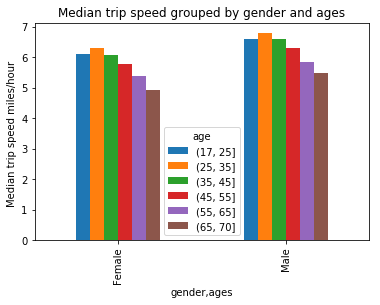

In [32]:
perf_groups['trip_speed'].median().unstack().plot.bar()
plt.title('Median trip speed grouped by gender and ages')
plt.xlabel('gender,ages')
plt.ylabel('Median trip speed miles/hour ')

plt.show()

In [48]:
#chicago bike usage count
df_stations.head()

,id,name,city,latitude,longitude,dpcapacity,online_date
id,,,,,,,
2,2,Buckingham Fountain,Chicago,41.876393,-87.620328,27,6/10/2013 10:43
3,3,Shedd Aquarium,Chicago,41.867226,-87.615355,55,6/10/2013 10:44
4,4,Burnham Harbor,Chicago,41.856268,-87.613348,23,6/10/2013 10:46
5,5,State St & Harrison St,Chicago,41.874053,-87.627716,23,6/10/2013 10:46
6,6,Dusable Harbor,Chicago,41.885041,-87.612794,39,6/10/2013 11:18


In [61]:
print(df_stations['city'].value_counts())
print(df_stations['city'].unique())

Chicago     520
Chicago      41
Oak Park     13
Evanston     11
Name: city, dtype: int64
['Chicago' 'Chicago ' 'Evanston' 'Oak Park']


There are duplicated Chicago entries. 

In [77]:
#create dataframe only include chicagos stations
st_chicago = df_stations[df_stations['city'] != 'Evanston']
st_chicago = st_chicago[st_chicago['city'] != 'Oak Park']

#store chicago station ids as nparray
st_chicago_id = np.array(st_chicago.index)

In [93]:
#counts rows 'from_station_id' is in chicago station ids.
print(df_2017[df_2017['from_station_id'].isin(st_chicago_id)].shape)
#counts rows 'to_station_id' is in chicago station ids.
print(df_2017[df_2017['to_station_id'].isin(st_chicago_id)].shape)

(3801673, 11)
(3801736, 11)


Number of bikes 'trip from Chicago' and 'trip to Chicago' are not same.
It seems that some users ride bikes across the cities.
I count both as bike in Chicago usage.

In [115]:
bikes = df_2017[['bikeid','tripduration','from_station_id','to_station_id']] # select only needed columns

from_chicago = bikes['from_station_id'].isin(st_chicago_id) # create boolean index for 'from Chicago' trips
to_chicago = bikes['to_station_id'].isin(st_chicago_id) # create boolean index for 'to Chicago' trips
from_to_chicago = from_chicago | to_chicago # create boolean index for both 'from or to Chicago' trips

bikes = bikes[from_to_chicago] # select trips 'from or to' Chicago

In [113]:
bikes_count.head()

,bikeid
2565,1471
3308,1232
3489,1215
3128,1210
5880,1173


      bikeid
2565    1471
3308    1232
3489    1215
3128    1210
5880    1173


Text(0,0.5,'Trip Counts')

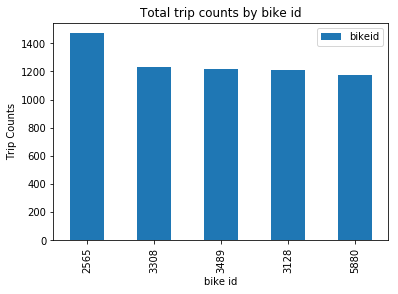

In [116]:
bikes_count = bikes['bikeid'].value_counts() 
bikes_count = pd.DataFrame(bikes_count.head())
print(bikes_count)

bikes_count.plot.bar()
plt.title('Total trip counts by bike id')
plt.xlabel('bike id')
plt.ylabel('Trip Counts')

In [117]:
bikes_duration = bikes[['bikeid','tripduration']]
bikes_duration.head()

,bikeid,tripduration
trip_id,,
13518905,5292,857
13518904,4408,236
13518903,696,348
13518902,4915,288
13518901,4247,415


        tripduration
bikeid              
2565    22370.016667
5880    20654.700000
5293    19865.416667
5479    19554.433333
5731    19315.866667


Text(0,0.5,'Total Duration minutes')

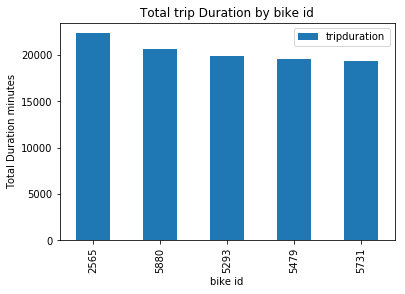

In [118]:
bikes_duration = bikes_duration.groupby('bikeid').sum().sort_values(by=['tripduration'],ascending=False).head()
bikes_duration['tripduration'] = bikes_duration['tripduration'] / 60 
print(bikes_duration)

bikes_duration.plot.bar()
plt.title('Total trip Duration by bike id')
plt.xlabel('bike id')
plt.ylabel('Total Duration minutes')

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [37]:
df_perf.head()

,trip_id,tripduration,from_station_id,to_station_id,gender,age,trip_distance,duration /hour,trip_speed
0,13518905,857,66,171,Male,28,2.200468,0.238056,9.243508
1,13518904,236,199,26,Male,27,0.480815,0.065556,7.334465
2,13518903,348,520,432,Female,38,0.556543,0.096667,5.757337
3,13518902,288,110,142,Male,32,0.590675,0.080000,7.383431
4,13518901,415,327,331,Female,28,0.937236,0.115278,8.130241


count    2.936525e+06
mean     6.979419e+02
std      9.124381e+02
min      6.000000e+01
25%      3.570000e+02
50%      5.710000e+02
75%      9.020000e+02
max      8.609600e+04
Name: tripduration, dtype: float64
571.0


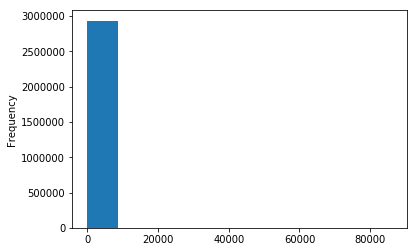

In [38]:
print(df_perf['tripduration'].describe())
print(df_perf['tripduration'].median())
df_perf['tripduration'].plot.hist()

Trip duration data has a large max value time.

I think it's because some users return the bike next day,so that they can fully use 24hours pass, or something so on.

count    2.774091e+06
mean     6.142667e+02
std      3.335424e+02
min      6.000000e+01
25%      3.460000e+02
50%      5.440000e+02
75%      8.320000e+02
max      1.483000e+03
Name: tripduration, dtype: float64
544.0
(2774091, 9)


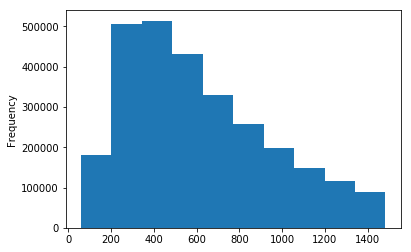

In [39]:
#For modeling,I only uses rows which duration is bellow some value(median + std)
train_df = df_perf[(df_perf['tripduration'] < ( df_perf['tripduration'].median() + df_perf['tripduration'].std())) ]

print(train_df['tripduration'].describe())
print(train_df['tripduration'].median())
print(train_df.shape)
train_df['tripduration'].plot.hist()

In [40]:
#pick values to model
train_df = train_df[['gender','age','trip_distance','tripduration','trip_speed']]

#set dummy values for gender.
train_df = pd.get_dummies(train_df, columns=["gender"])

print(train_df.shape)
train_df.corr()

(2774091, 6)


,age,trip_distance,tripduration,trip_speed,gender_Female,gender_Male
age,1.000000,-0.041822,0.004016,-0.109342,-0.071195,0.071195
trip_distance,-0.041822,1.000000,0.844439,0.448562,0.023942,-0.023942
tripduration,0.004016,0.844439,1.000000,-0.028686,0.090407,-0.090407
trip_speed,-0.109342,0.448562,-0.028686,1.000000,-0.114793,0.114793
gender_Female,-0.071195,0.023942,0.090407,-0.114793,1.000000,-1.000000
gender_Male,0.071195,-0.023942,-0.090407,0.114793,-1.000000,1.000000


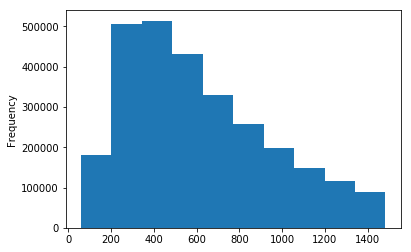

In [41]:
train_df.tripduration.plot.hist()

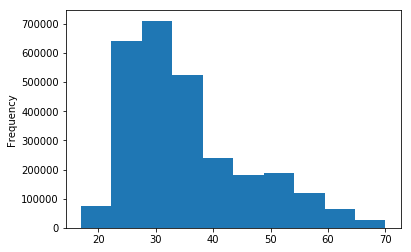

In [42]:
train_df.age.plot.hist()

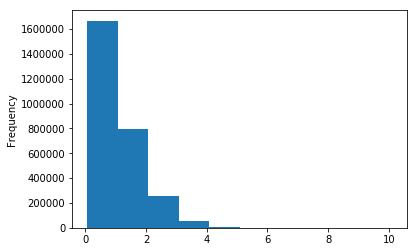

In [43]:
train_df.trip_distance.plot.hist()

In [44]:
train_df.trip_distance.min()

0.064280201871925013

In [45]:
train_df.head()

,age,trip_distance,tripduration,trip_speed,gender_Female,gender_Male
0,28,2.200468,857,9.243508,0,1
1,27,0.480815,236,7.334465,0,1
2,38,0.556543,348,5.757337,1,0
3,32,0.590675,288,7.383431,0,1
4,28,0.937236,415,8.130241,1,0


In [49]:
X = train_df[['age','trip_speed','trip_distance','gender_Female','gender_Male']]
y = train_df['tripduration']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

In [50]:
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('model', LinearRegression())
]

pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)

print('RMSE: {}'.format(rmse))

Training score: 0.9887608401012962
Test score: 0.9519823279810231
RMSE: 73.1437470391787


steps = [ ('scalar', StandardScaler()), ('poly', PolynomialFeatures(degree=2)), ('model', Lasso(alpha=0.1, fit_intercept=True)) ]

lasso_pipe = Pipeline(steps)

lasso_pipe.fit(X_train, y_train)

print('Training score: {}'.format(lasso_pipe.score(X_train, y_train))) 
print('Test score: {}'.format(lasso_pipe.score(X_test, y_test)))